## Library setup

In [145]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/captions.txt
/kaggle/input/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/Images/2366643786_9c9a830db8.jpg
/kaggle/input/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/Images/2190227737_6e0bde2623.jpg
/kaggle/input/Images/2752809449_632cd991b3.jpg
/kaggle/input/Images/3097776588_312932e438.jpg
/kaggle/input/Images/1206506157_c7956accd5.jpg
/kaggle/input/Images/1319634306_816f21677f.jpg
/kaggle/input/Images/2465218087_fca77998c6.jpg
/kaggle/input/Images/3351493005_6e5030f596.jpg
/kaggle/input/Images/2949337912_beba55698b.jpg
/kaggle/input/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/Images/3543600125_223747ef4c.jpg
/kaggle/input/Images/2174206711_11cb712a8d.jpg
/kaggle/input/Images/280706862_14c30d734a.jpg
/kaggle/input/Images/2100735137_05c6079537.jpg
/kaggle/input/Images/3131632154_098f86f4cb.jpg
/kaggle/input/Images/2236016316_f476cbbf06.jpg
/kaggle/input/Images/3335375223_b4da8df523.jpg
/kaggle/input/Images/929679367_ff8c7

In [146]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

# Data and Pre-processing

In [147]:
# Path to the images
images_directory = '/kaggle/input/Images/'
# Path to the captions
captions_path = '/kaggle/input/captions.txt'

In [148]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

## Cleaning the captions

In [149]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [150]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

## Visualizing some of the images along with their corresponding captions

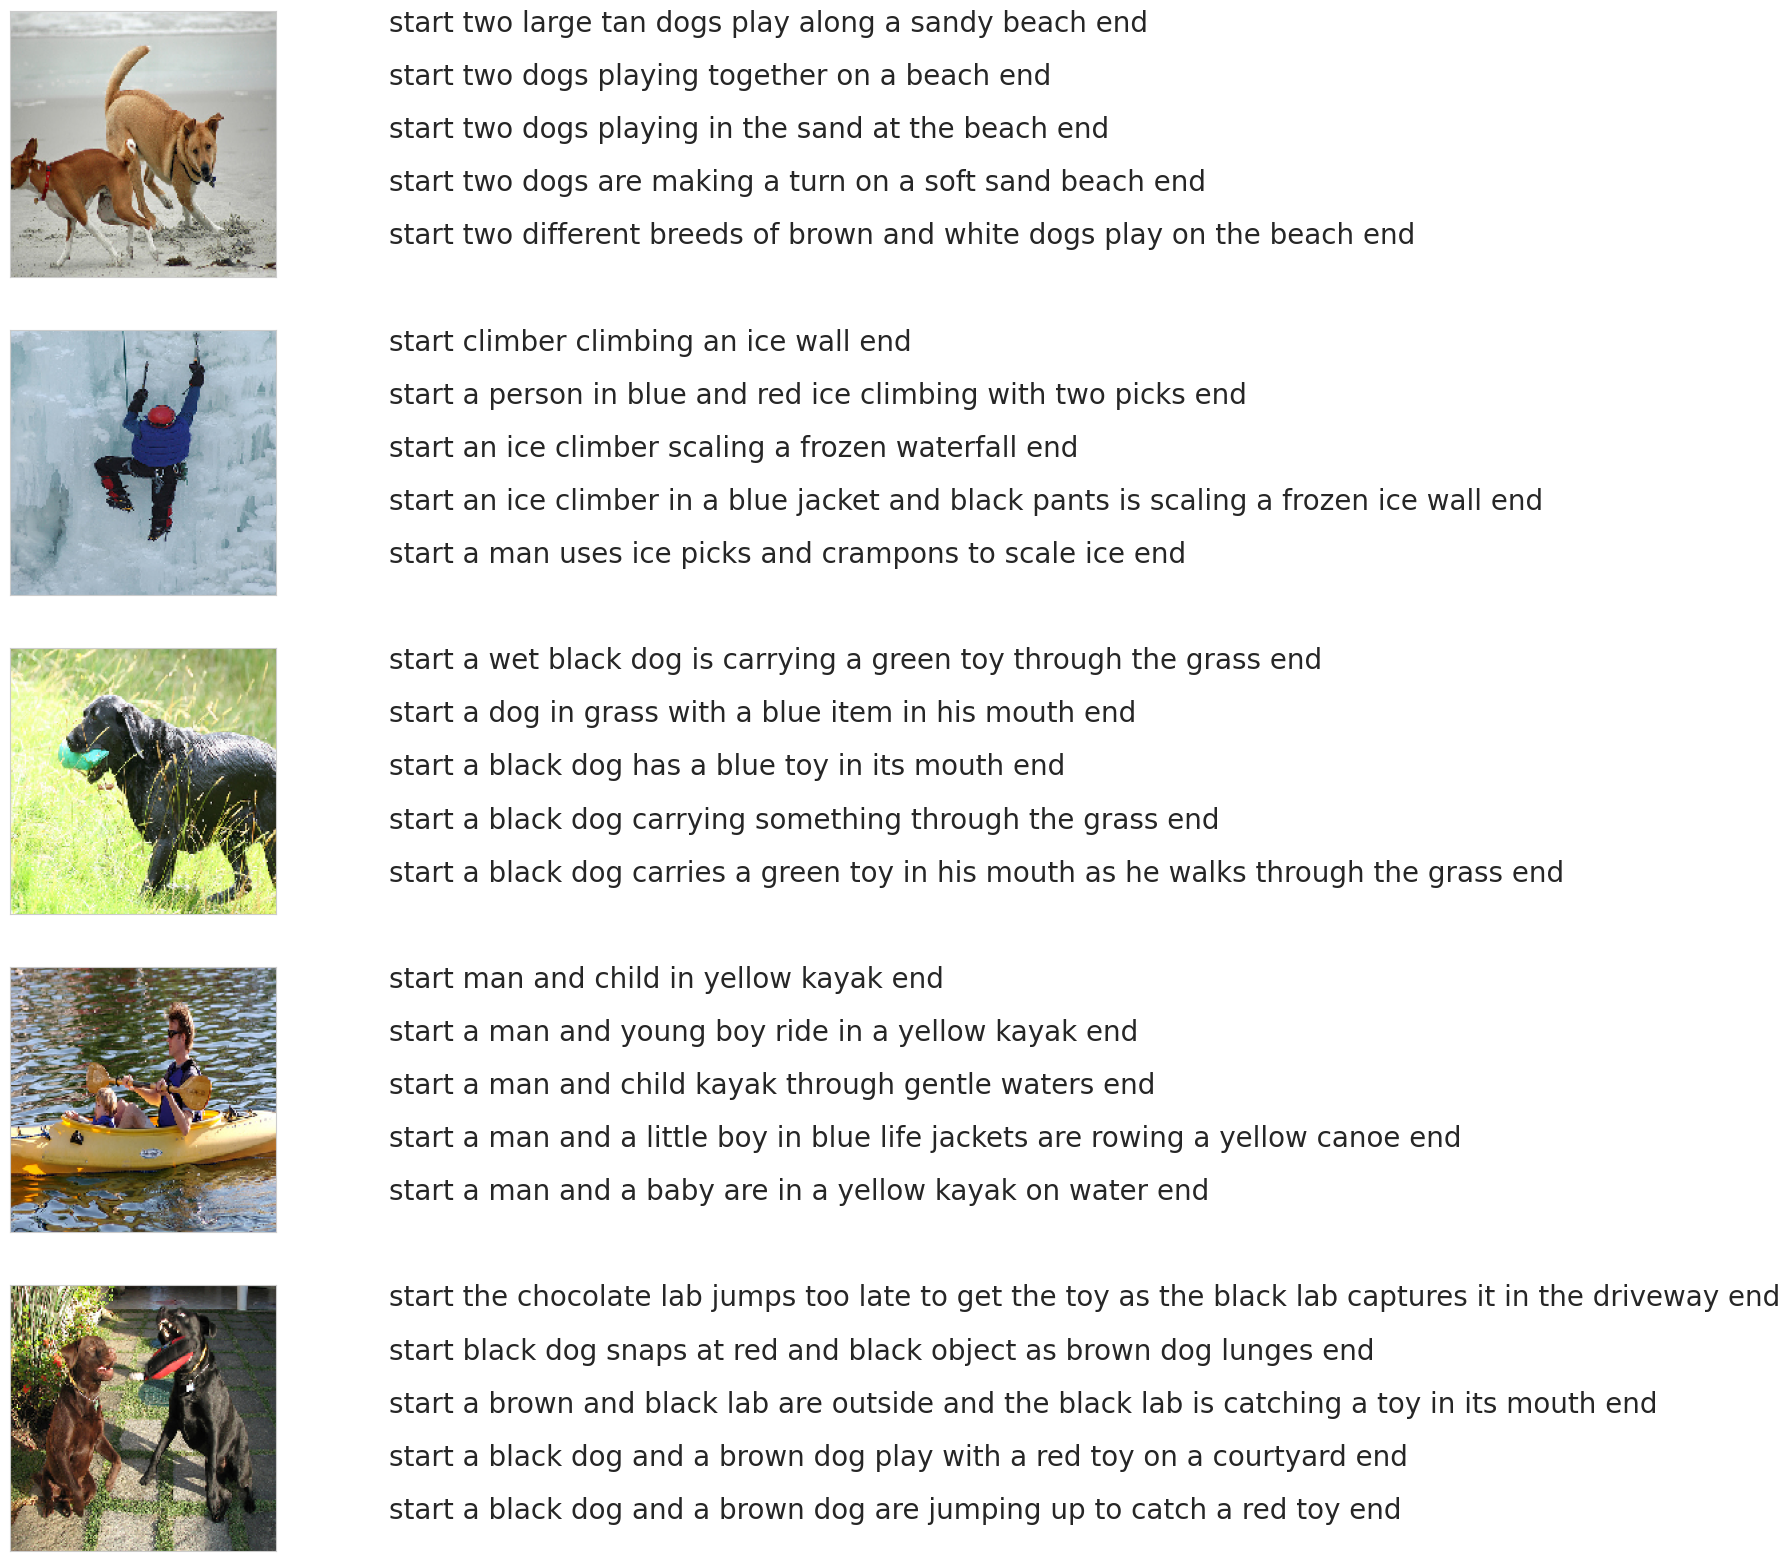

In [151]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

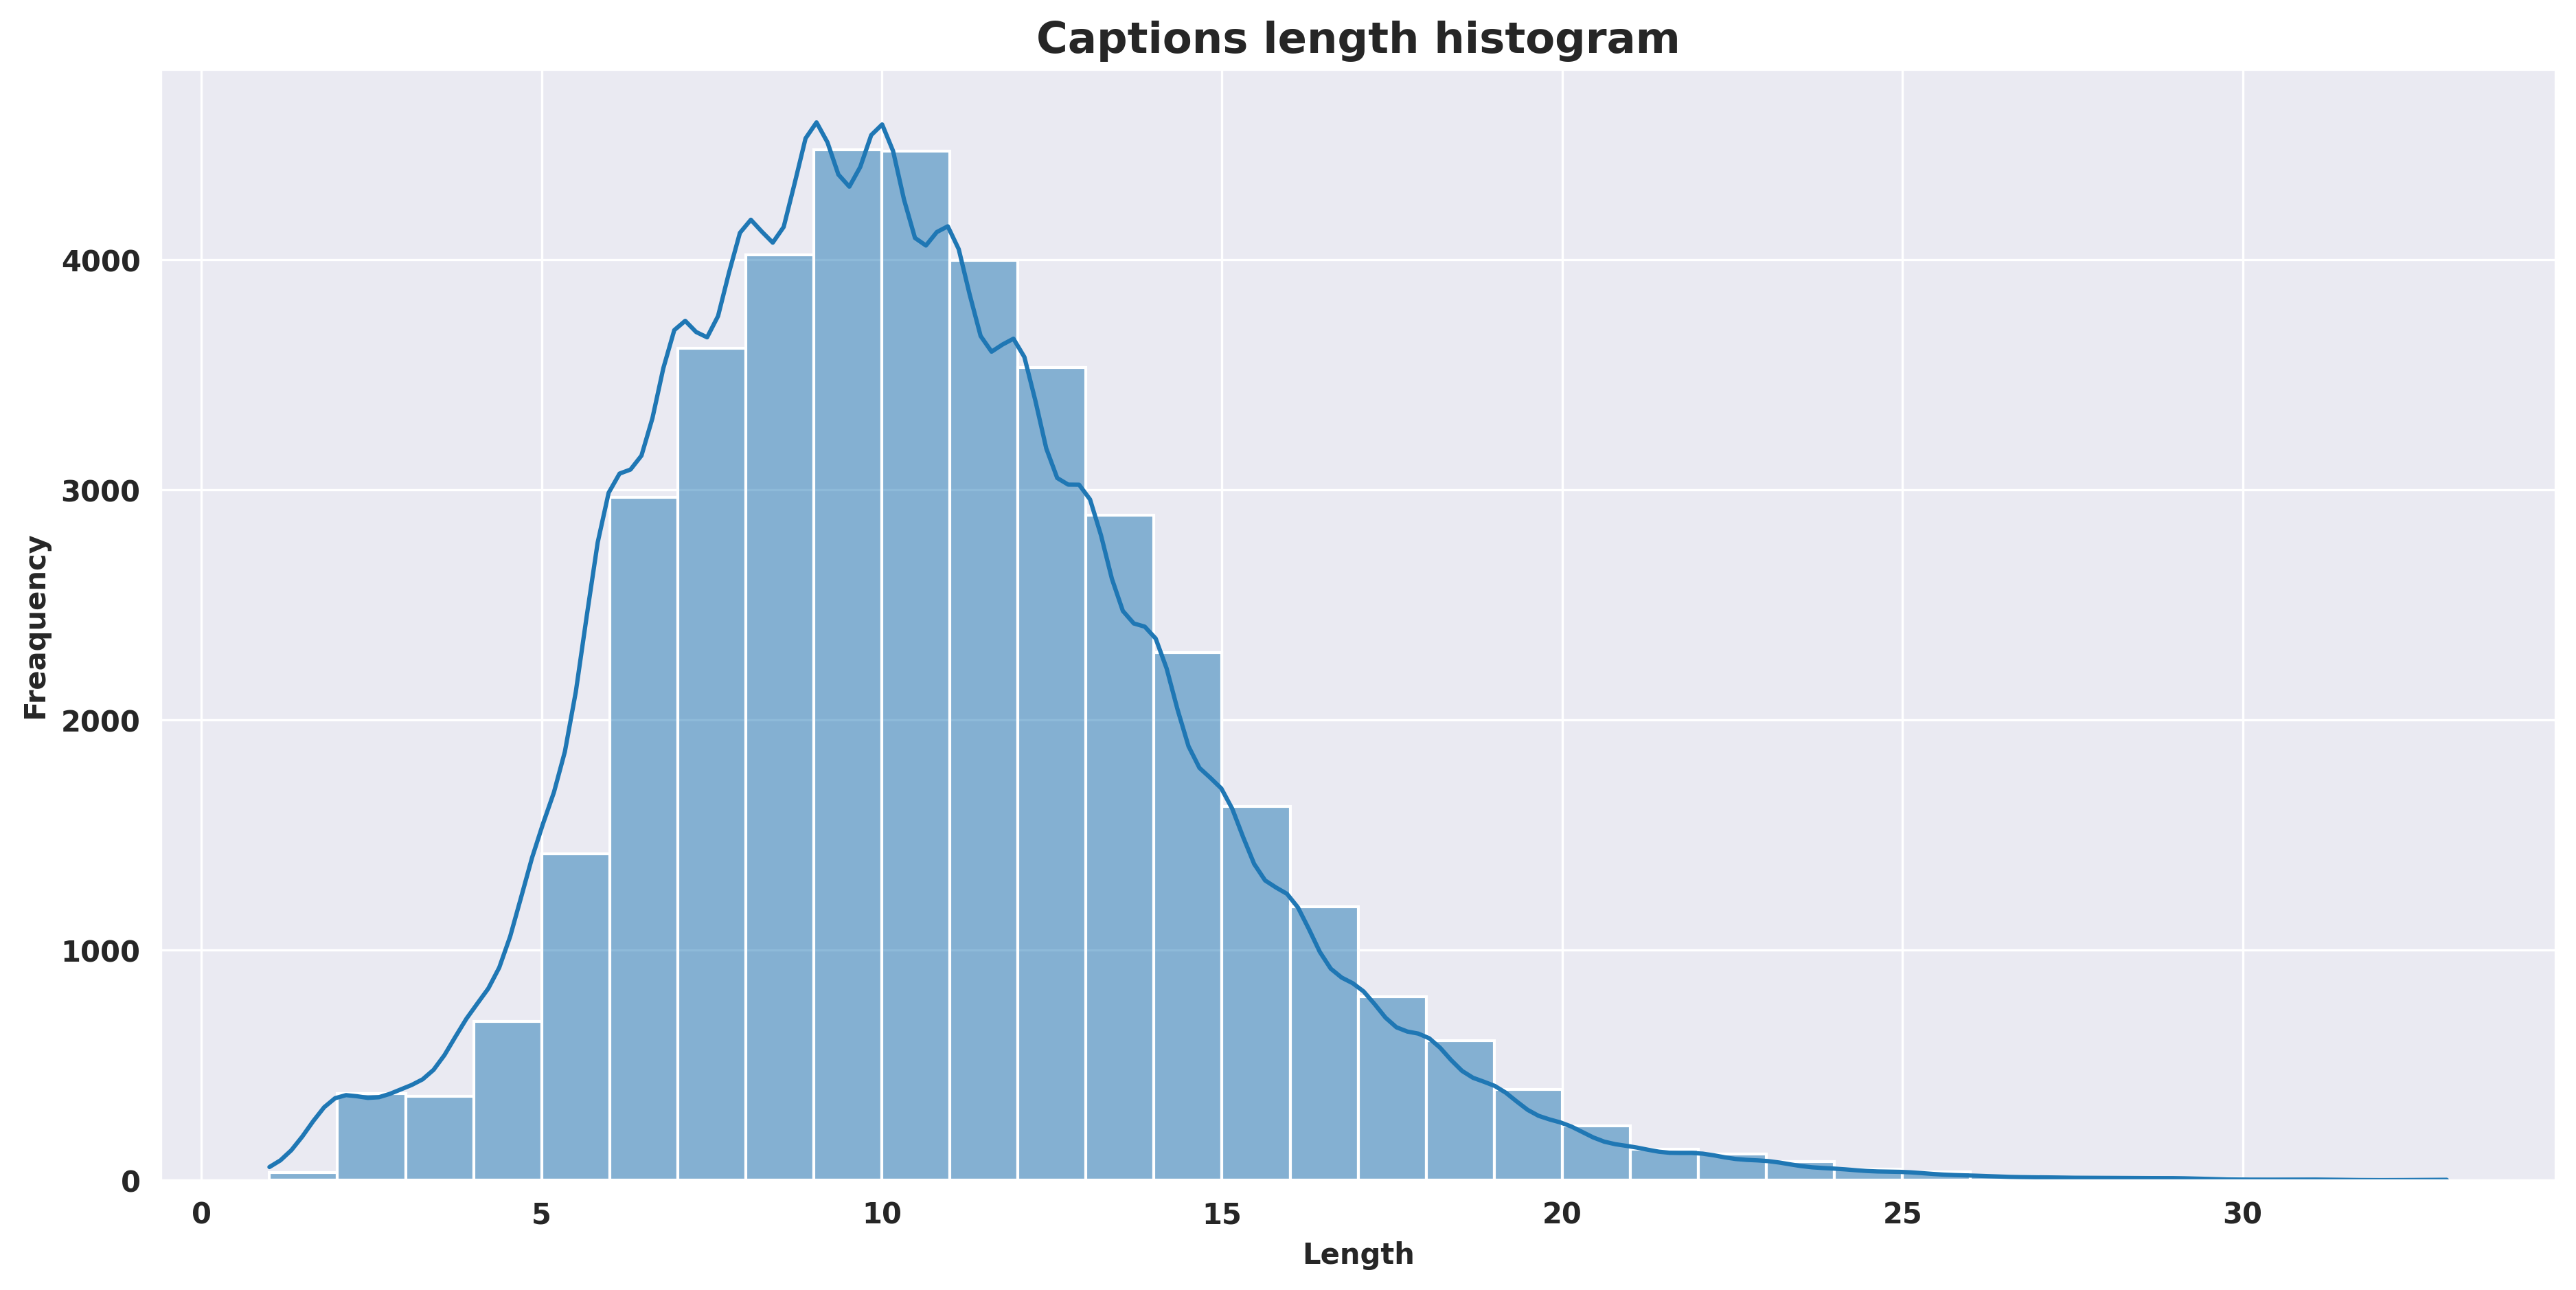

In [152]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(cleaned_captions)

### **Tokenizing** captions and setting **vocab size**

In [ ]:
# Tokenizing the captions and creating word-to-index mapping
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

8586

### Splitting the data into tain, validation and test sets

In [154]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.2, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.5, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    
    if image_id in train_image_ids:
        train_captions.append(caption)
        
    elif image_id in val_image_ids:
        val_captions.append(caption)        

    elif image_id in test_image_ids:
        test_captions.append(caption)
        
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
 '1002674143_1b742ab4b8.jpg\tstart a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl end\n',
 '1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 6472.0,
 809.0,
 810.0)

In [155]:

import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

# 1. Define the augmentation pipeline for training images
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

## **Extracting Image features** using **The InceptionV3** model

In [157]:


# 2. Preprocess image (with optional augmentation)
def preprocess_image(image_path, augment=False):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    if augment:
        img = next(datagen.flow(img, batch_size=1))
    else:
        img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img

# 3. Extract features using the preprocessed image
def extract_image_features(model, image_path, augment=False):
    img = preprocess_image(image_path, augment=augment)
    features = model.predict(img, verbose=0)
    return features

# 4. Load the pre-trained InceptionV3 model (excluding the classification layer)
inception_v3_model = InceptionV3(weights='imagenet', input_shape=(299, 299, 3))
inception_v3_model = Model(
    inputs=inception_v3_model.input,
    outputs=inception_v3_model.layers[-2].output  # Exclude final dense classification layer
)

# 5. Extract features for all images and apply augmentation for training images only
train_image_features = {}
val_image_features = {}
test_image_features = {}

pbar = tqdm(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)

    if image_id in train_image_ids:
        features = extract_image_features(inception_v3_model, image_path, augment=False)  # ✅ Augment training
        train_image_features[image_id] = features.flatten()

    elif image_id in val_image_ids:
        features = extract_image_features(inception_v3_model, image_path, augment=False)
        val_image_features[image_id] = features.flatten()

    elif image_id in test_image_ids:
        features = extract_image_features(inception_v3_model, image_path, augment=False)
        test_image_features[image_id] = features.flatten()

    else:
        print(f"Unknown image ID: {image_id}")

    pbar.update(1)

pbar.close()


100%|██████████| 8091/8091 [12:09<00:00, 11.09it/s]


# **Data Setup for Model Input**
> #### To **optimize** memory usage, it's suggested to use **generators** to collect the data

In [171]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            
            yield (np.array(X_images), np.array(X_captions)), np.array(y)
         
        
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 256
batch_size_val =256

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [172]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3052, 2048)
X_captions: (3052, 34)
y: (3052, 8586)
Validation sample batch shapes:
X_images: (2907, 2048)
X_captions: (2907, 34)
y: (2907, 8586)


In [ ]:
from tensorflow.keras.regularizers import l2
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu',kernel_regularizer=l2(0.001))(fe1)
    fe3 = BatchNormalization()(fe2)

    # Decoder
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se1 = Dropout(0.3)(se1)  # Dropout after Embedding
    se2 = LSTM(256,kernel_regularizer=l2(0.001))(se1)
    se2 = Dropout(0.3)(se2)  # Dropout after LSTM

    # Merge and output
    decoder1 = add([fe3, se2])
    decoder1 = Dropout(0.3)(decoder1)  # Dropout after merge
    decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

    
# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
caption_model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']  
)

caption_model.summary()

Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Sequence_Input            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Features_Input            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 34, 256)        │      2,198,016 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_408   │ (None, 2048)           │          8,192 │ Features_Input[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_48 (Dropout)      │ (None, 34, 256)        │              0 │ embedding_16[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_16 (NotEqual)   │ (None, 34)             │              0 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 256)            │        524,544 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_16 (LSTM)            │ (None, 256)            │        525,312 │ dropout_48[0][0],      │
│                           │                        │                │ not_equal_16[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_409   │ (None, 256)            │          1,024 │ dense_32[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_49 (Dropout)      │ (None, 256)            │              0 │ lstm_16[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 256)            │              0 │ batch_normalization_4… │
│                           │                        │                │ dropout_49[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_50 (Dropout)      │ (None, 256)            │              0 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 256)            │         65,792 │ dropout_50[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 8586)           │      2,206,602 │ dense_33[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

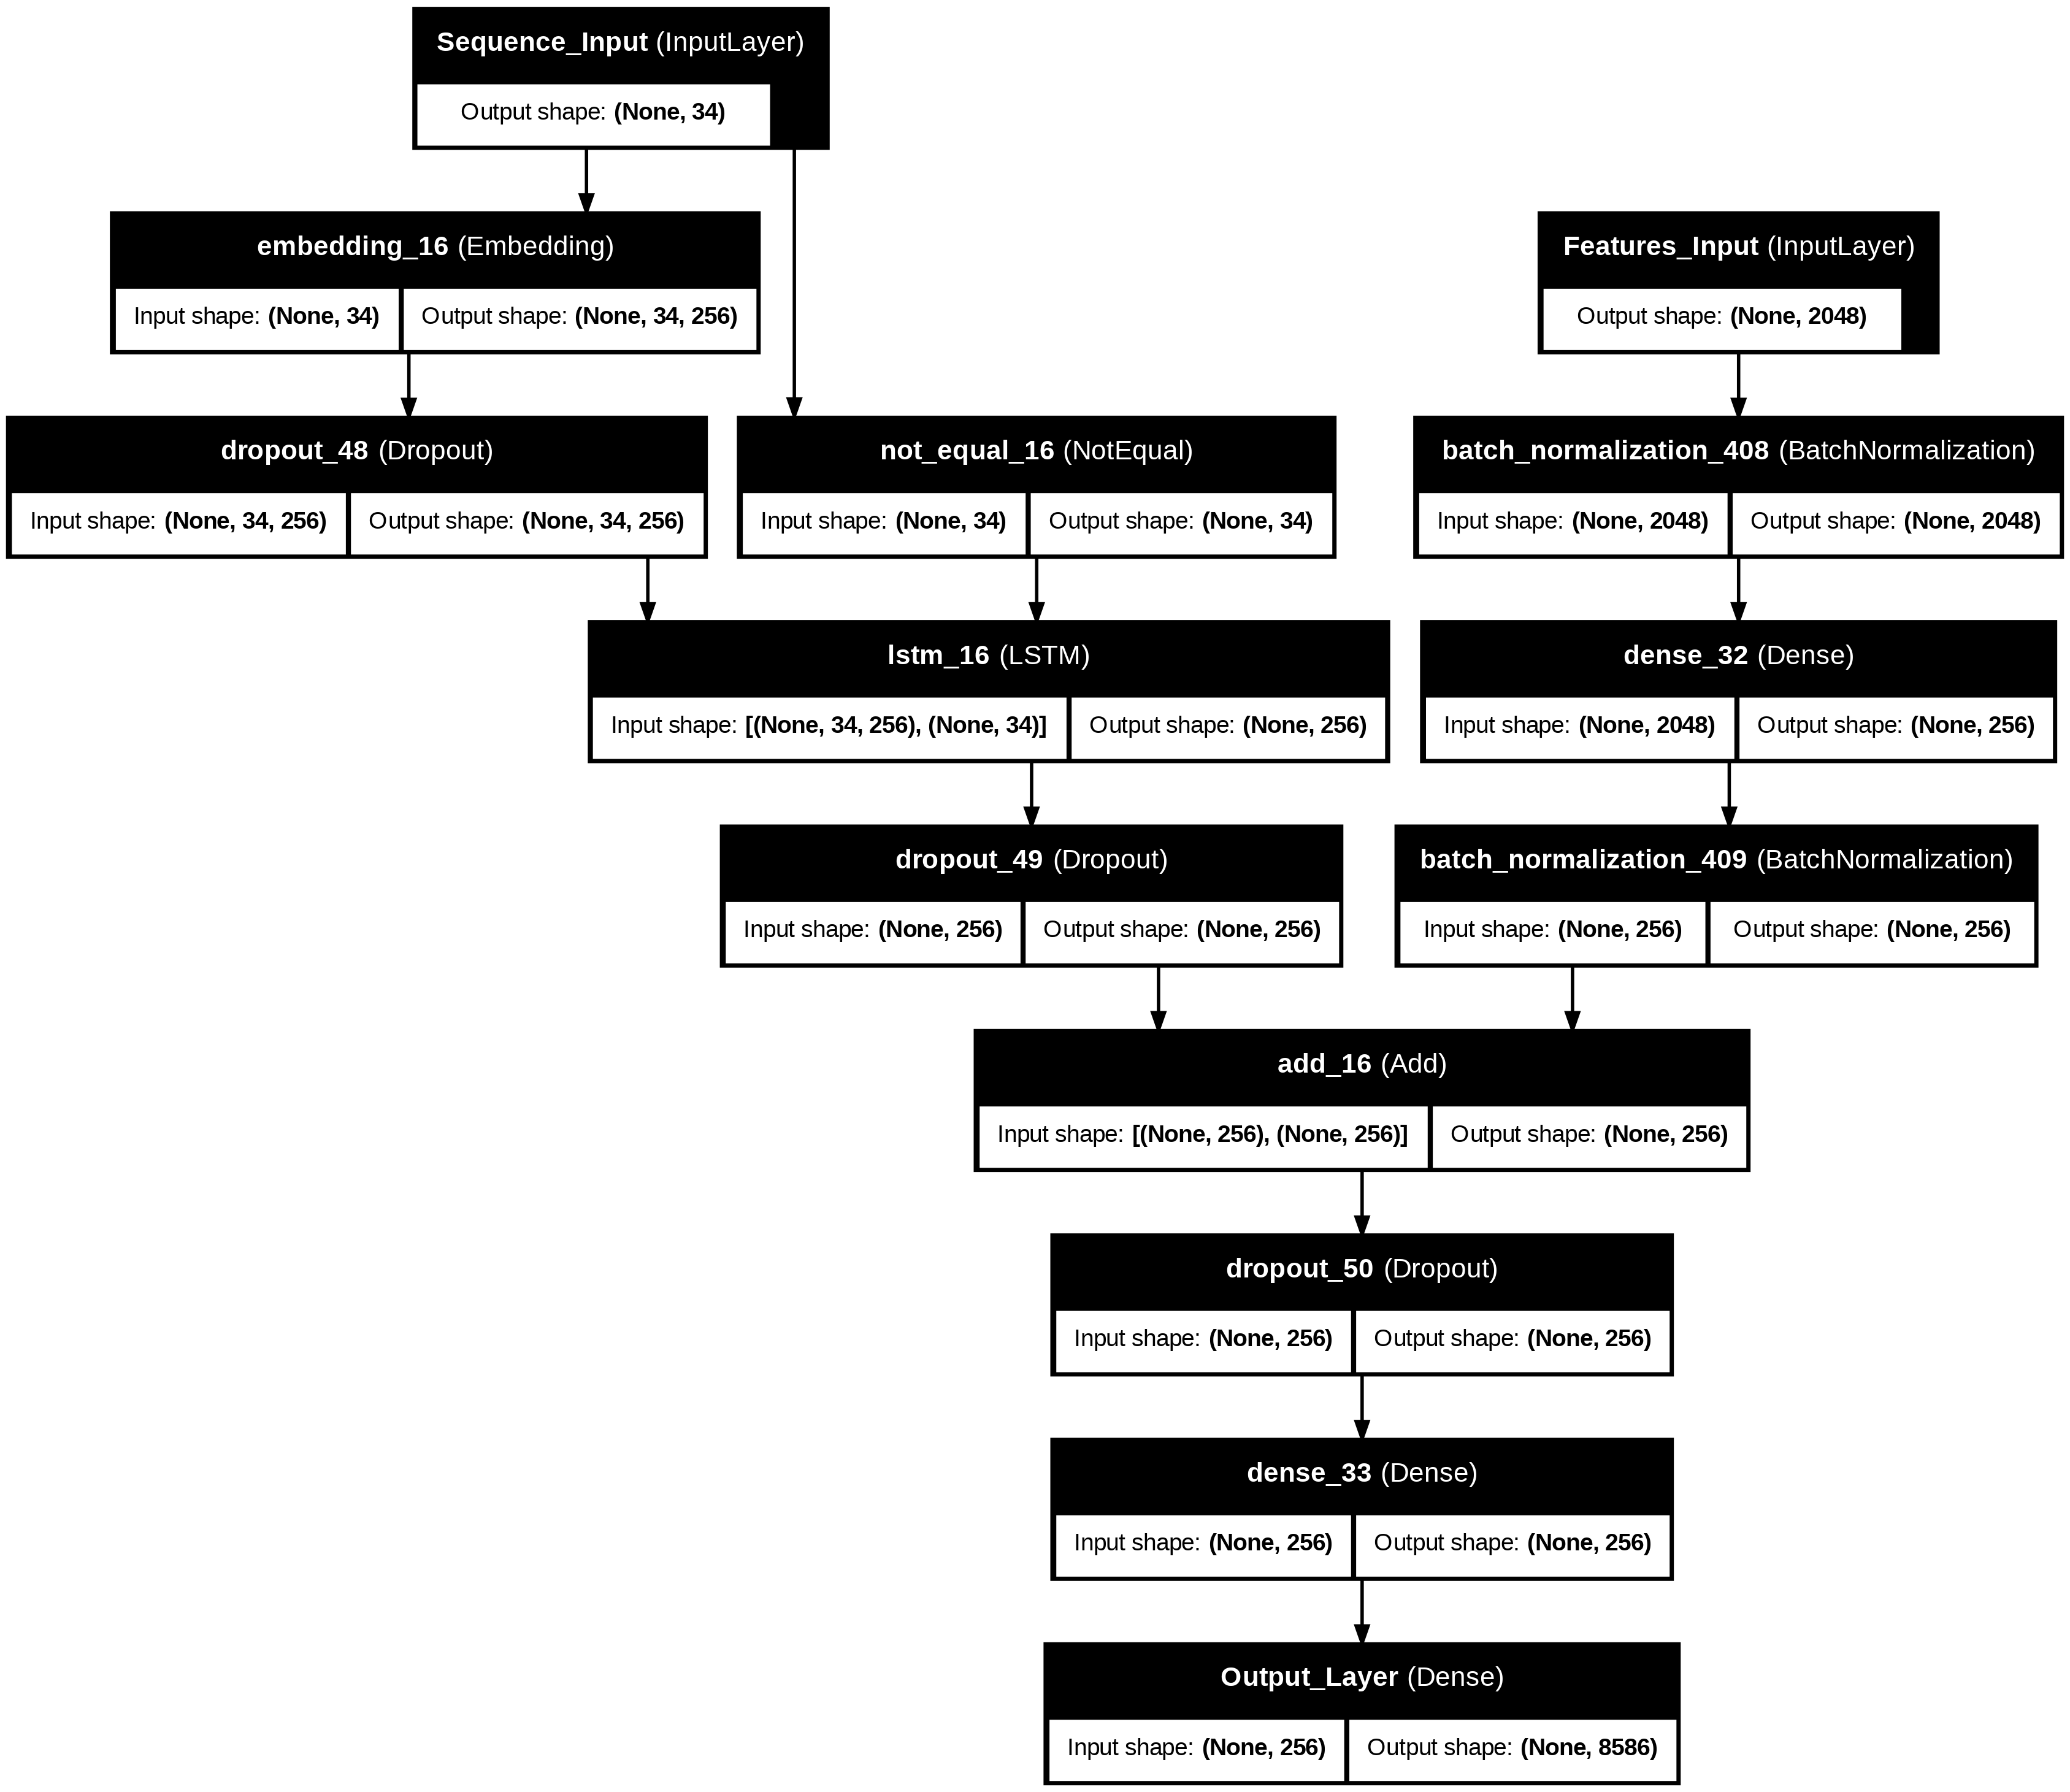

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model, 
           to_file='caption_model.png',  # can change the file name
           show_shapes=True,             #  Shows input/output shapes
           show_layer_names=True,        #  Shows layer names (default)
           expand_nested=True)           # Optional: expands nested models if any


In [179]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = caption_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_data_generator,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping]
)


Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 469ms/step - accuracy: 0.1018 - loss: 7.0152 - val_accuracy: 0.2132 - val_loss: 5.0654
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - accuracy: 0.2437 - loss: 4.6251 - val_accuracy: 0.2945 - val_loss: 4.1600
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - accuracy: 0.3020 - loss: 3.9558 - val_accuracy: 0.3156 - val_loss: 3.8987
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - accuracy: 0.3223 - loss: 3.6817 - val_accuracy: 0.3273 - val_loss: 3.7677
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.3352 - loss: 3.5189 - val_accuracy: 0.3368 - val_loss: 3.7204
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.3467 - loss: 3.3920 - val_accuracy: 0.3423 - val_loss: 3.6823
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step - accuracy: 0.3557 - loss: 3.2938 - val_accuracy: 0.3449 - val_loss: 3.6694
Epoch 8/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - accuracy: 0.3628 - loss: 3

# Training the mode


### Visualizing the model performance

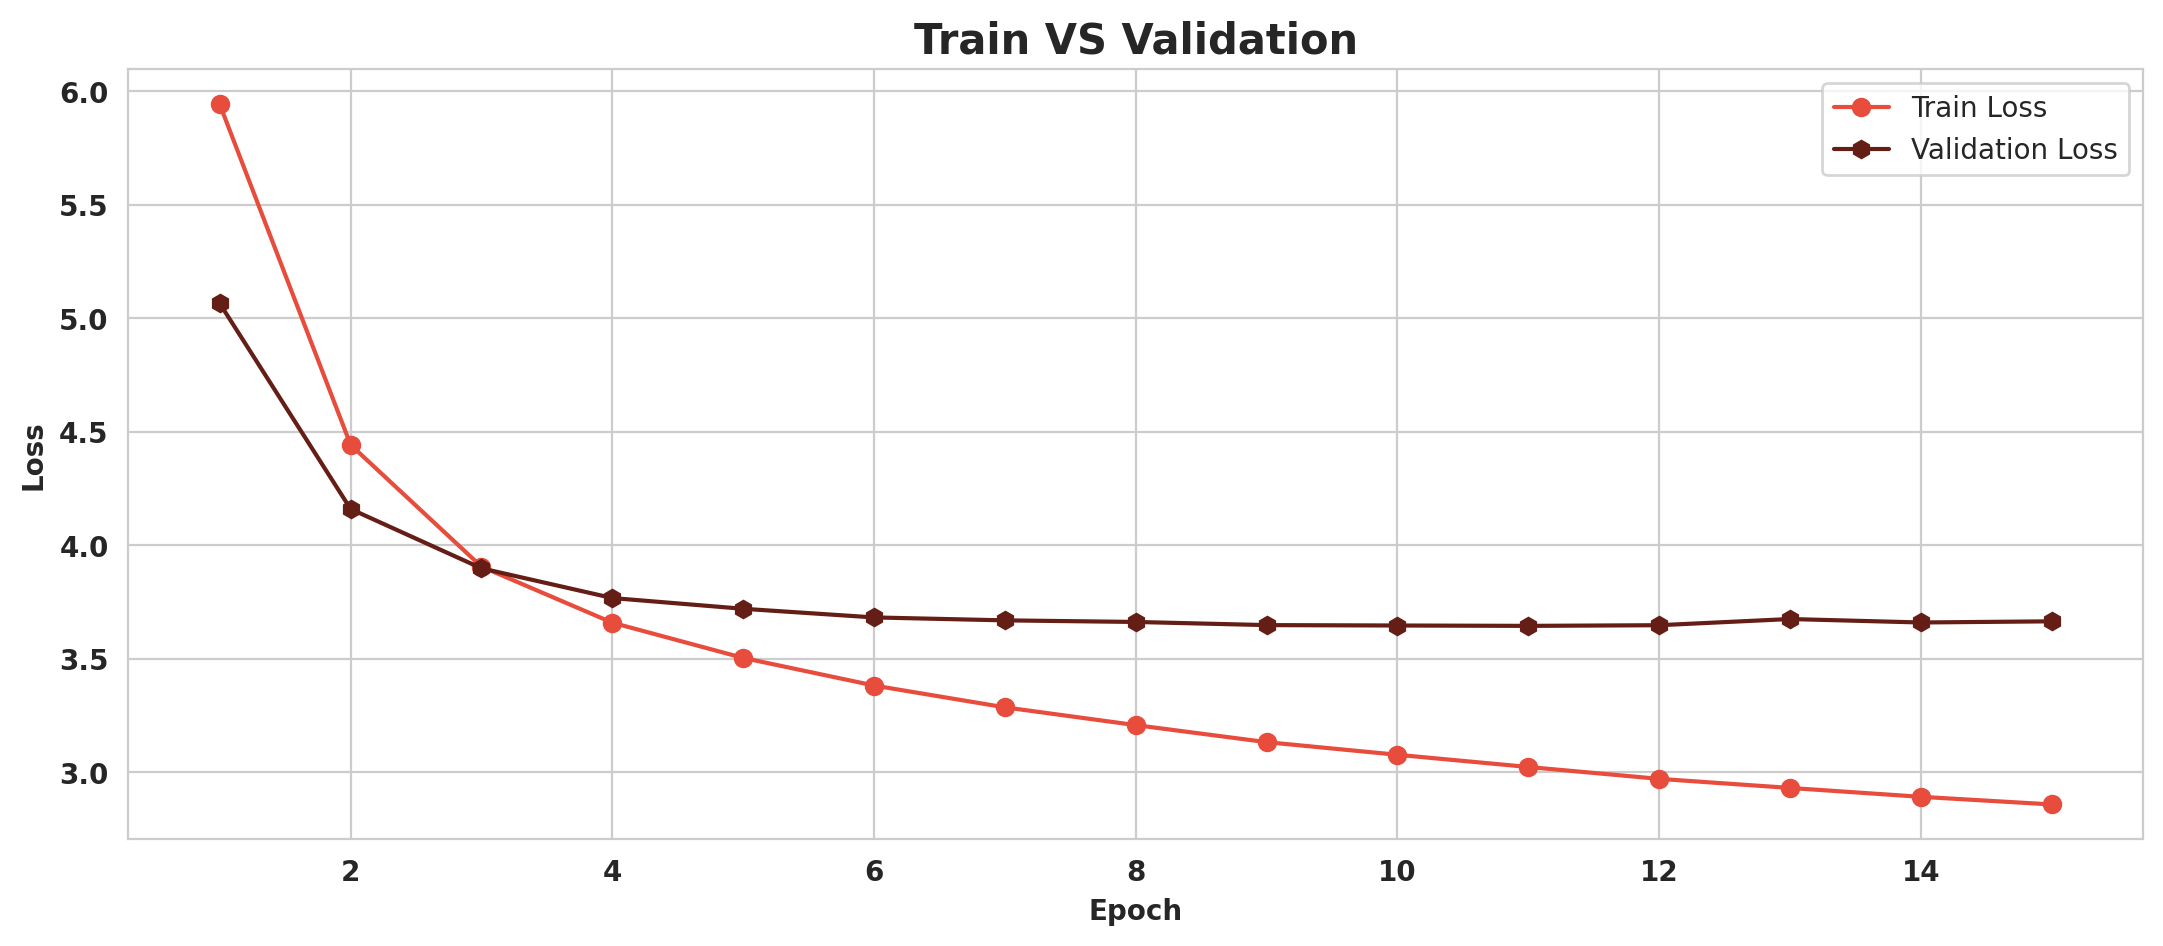

In [181]:
plt.figure(figsize=(13, 5), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

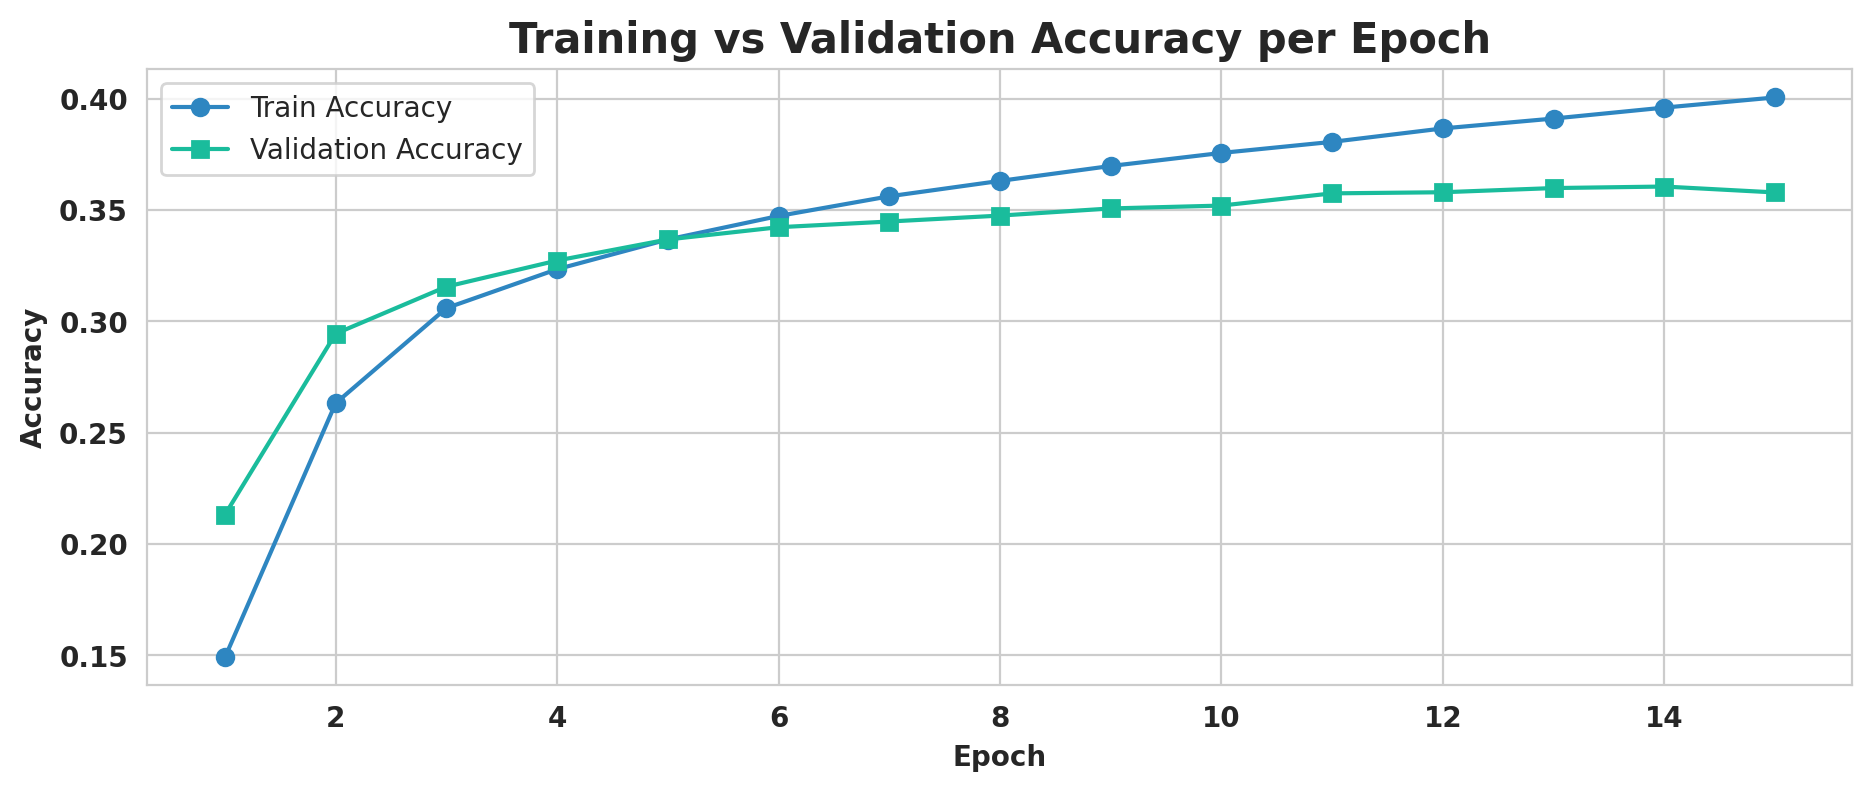

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(11, 4), dpi=200)
sns.set_style('whitegrid')

# Plot training accuracy
plt.plot([x + 1 for x in range(len(history.history['accuracy']))], history.history['accuracy'],
         color='#2E86C1', marker='o', label='Train Accuracy')

# Plot validation accuracy
plt.plot([x + 1 for x in range(len(history.history['val_accuracy']))], history.history['val_accuracy'],
         color='#1ABC9C', marker='s', label='Validation Accuracy')

# Styling
plt.title('Training vs Validation Accuracy per Epoch', fontsize=15, fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [183]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post').reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [184]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Sequence of most probable words based on the previous steps
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            
            # Sorting predictions by the probability and taking the last K_beams items.
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            # Getting the top <K_beams>(n) predictions and creating a 
            #                              new list so as to put them via the model again.
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [186]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [188]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy, beam_search):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [189]:
# Generating captions
generated_captions = {}

pbar = tqdm(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

100%|██████████| 810/810 [12:33<00:00,  1.07it/s]


## Visualizing some of the **test images** along with their corresponding **generated captions**

In [190]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_average_bleu(test_actual_captions, generated_captions):
    smooth = SmoothingFunction().method1
    
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []

    for image_id in generated_captions:
        reference_captions = [cap.split() for cap in test_actual_captions[image_id]]
        generated_caption = generated_captions[image_id].split()

        bleu1 = sentence_bleu(reference_captions, generated_caption, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
        bleu2 = sentence_bleu(reference_captions, generated_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
        bleu3 = sentence_bleu(reference_captions, generated_caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
        bleu4 = sentence_bleu(reference_captions, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)

    print("Average BLEU-1:", round(np.mean(bleu1_scores), 4))
    print("Average BLEU-2:", round(np.mean(bleu2_scores), 4))
    print("Average BLEU-3:", round(np.mean(bleu3_scores), 4))
    print("Average BLEU-4:", round(np.mean(bleu4_scores), 4))


In [191]:
compute_average_bleu(test_actual_captions, generated_captions)


Average BLEU-1: 0.5145
Average BLEU-2: 0.3321
Average BLEU-3: 0.1995
Average BLEU-4: 0.1277


In [200]:
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import os
import random

def show_side_by_side_caption_eval(actual_captions_dict, predicted_captions_dict, images_directory, num_samples=5, fixed_image_ids=None):
    smooth = SmoothingFunction().method1

    if fixed_image_ids is not None:
        image_ids = fixed_image_ids
    else:
        image_ids = random.sample(list(predicted_captions_dict.keys()), num_samples)

    plt.figure(figsize=(14, len(image_ids) * 4))

    for i, image_id in enumerate(image_ids):
        actual = [cap.replace("start ", "").replace(" end", "").strip().split()
                  for cap in actual_captions_dict[image_id]]
        predicted = predicted_captions_dict[image_id].strip().split()

        bleu1 = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
        bleu2 = sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
        bleu3 = sentence_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
        bleu4 = sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

        # Load image
        img_path = os.path.join(images_directory, image_id)
        img = Image.open(img_path)

        # Left subplot: Image
        ax_img = plt.subplot(len(image_ids), 2, 2*i + 1)
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.set_title(f"Image: {image_id}", fontsize=10)

        # Right subplot: Texts
        ax_text = plt.subplot(len(image_ids), 2, 2*i + 2)
        ax_text.axis('off')

        actual_text = '\n'.join(['• ' + ' '.join(a) for a in actual])
        predicted_text = ' '.join(predicted)
        bleu_text = f"\nBLEU-1: {round(bleu1, 4)} | BLEU-2: {round(bleu2, 4)}\nBLEU-3: {round(bleu3, 4)} | BLEU-4: {round(bleu4, 4)}"

        display_text = f"🟩 Actual Captions:\n{actual_text}\n\n🟦 Predicted Caption:\n{predicted_text}\n\n📊 BLEU Scores:\n{bleu_text}"

        ax_text.text(0, 1, display_text, ha='left', va='top', fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()


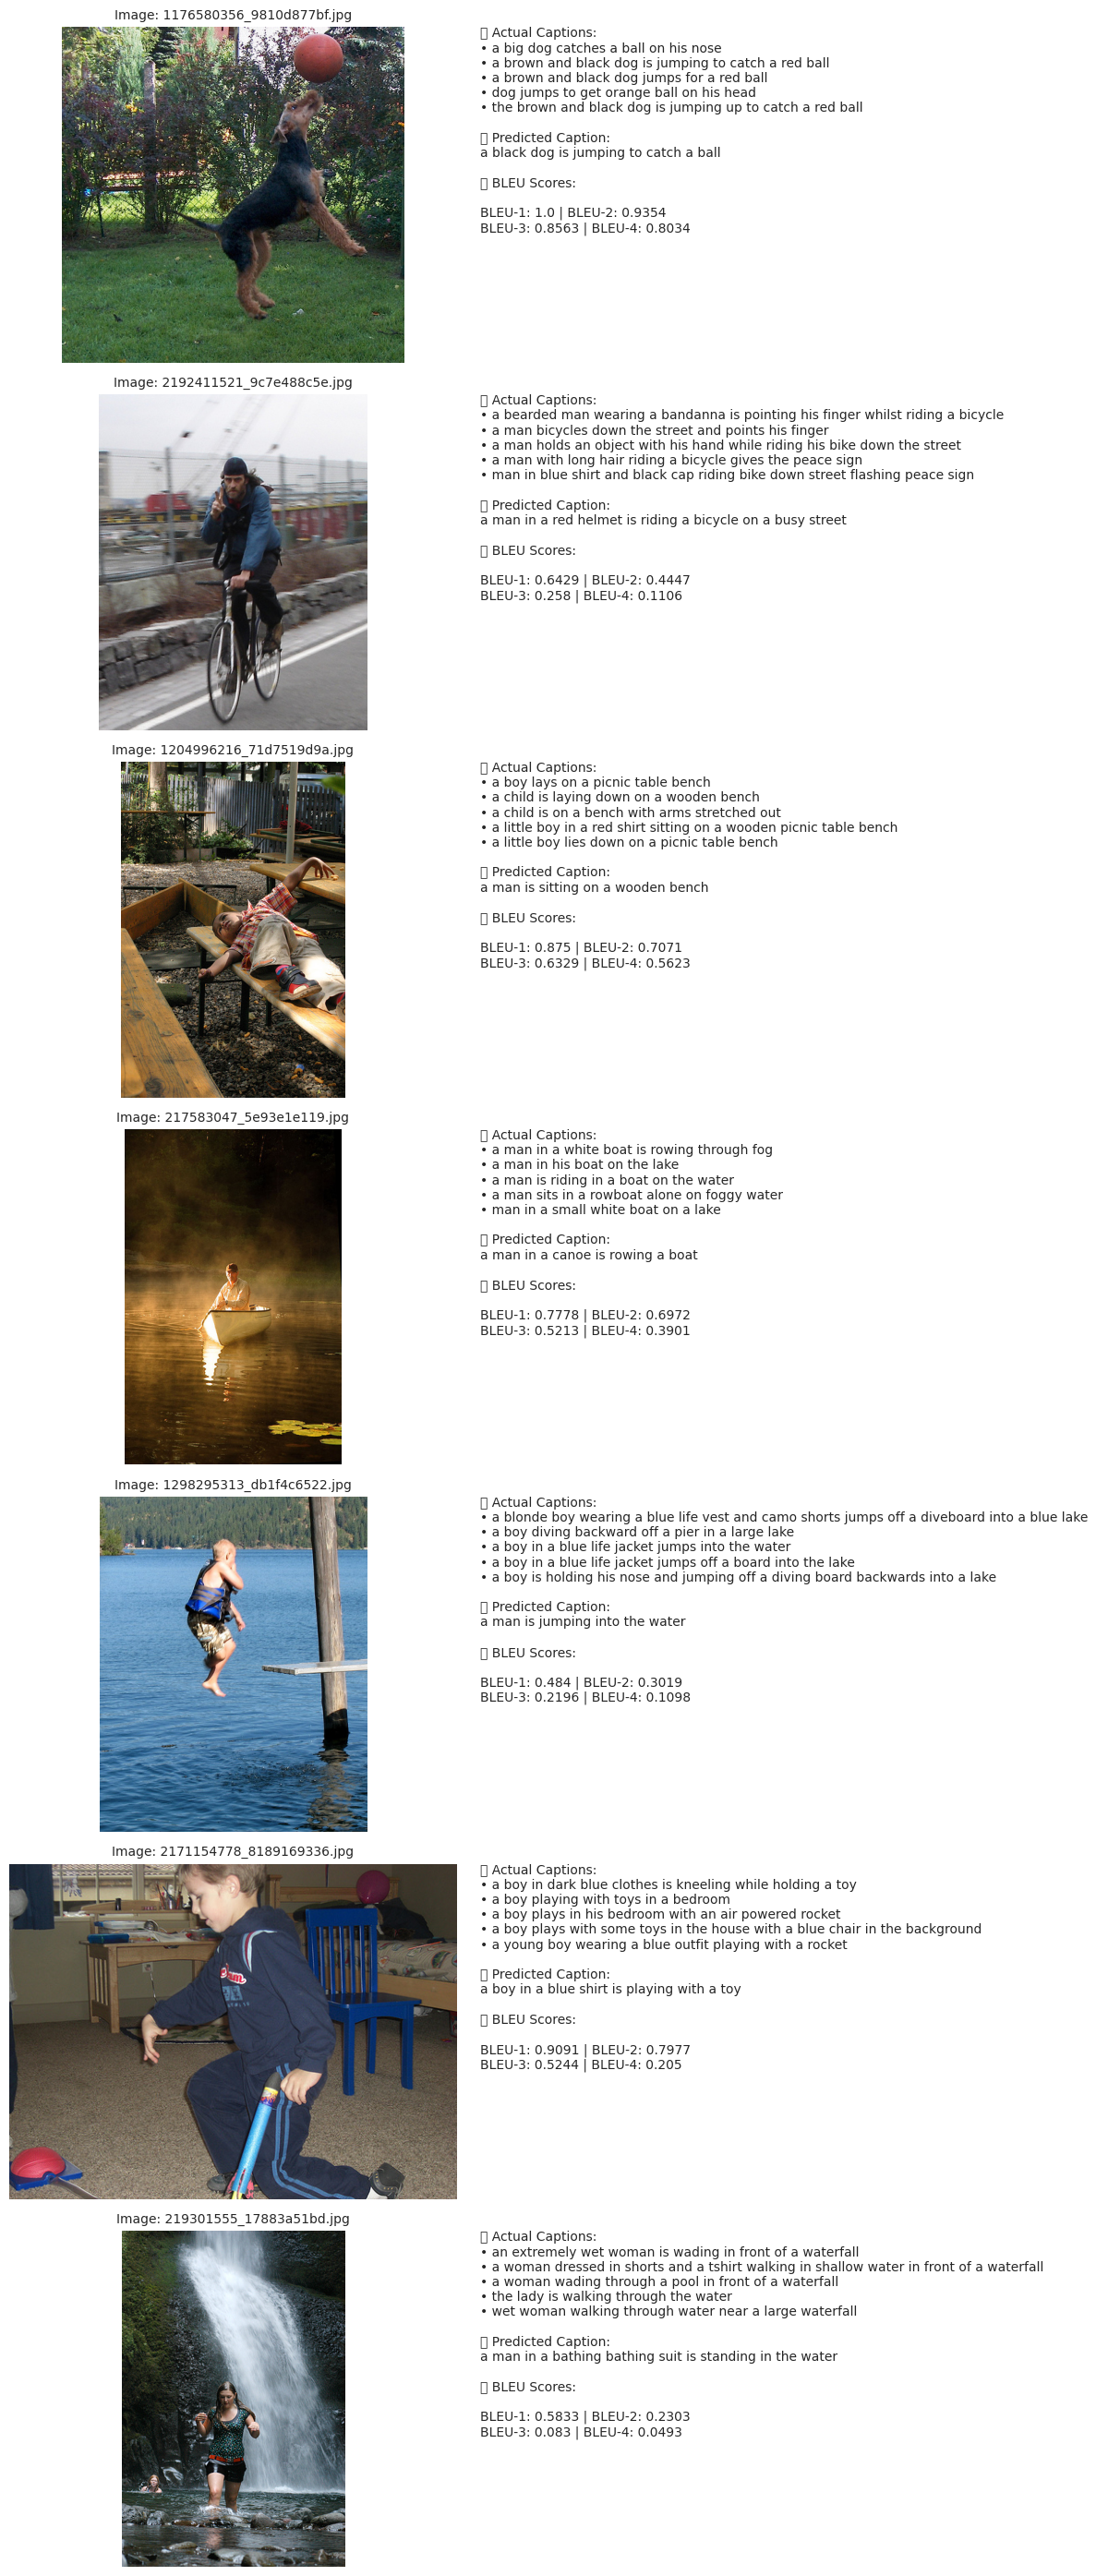

In [211]:
show_side_by_side_caption_eval(
    test_actual_captions,
    generated_captions,
    images_directory,
    fixed_image_ids=[
 '1176580356_9810d877bf.jpg',
 '2192411521_9c7e488c5e.jpg',
 '1204996216_71d7519d9a.jpg',
 '217583047_5e93e1e119.jpg',
 '1298295313_db1f4c6522.jpg','2171154778_8189169336.jpg','219301555_17883a51bd.jpg'])



In [194]:
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random
import os

def show_side_by_side_caption_eval(actual_captions_dict, predicted_captions_dict, images_directory, num_samples=5):
    smooth = SmoothingFunction().method1
    image_ids = random.sample(list(predicted_captions_dict.keys()), num_samples)

    plt.figure(figsize=(14, num_samples * 4))

    for i, image_id in enumerate(image_ids):
        actual = [cap.replace("start ", "").replace(" end", "").strip().split() for cap in actual_captions_dict[image_id]]
        predicted = predicted_captions_dict[image_id].strip().split()

        bleu1 = sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
        bleu2 = sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
        bleu3 = sentence_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
        bleu4 = sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

        # Load image
        img_path = os.path.join(images_directory, image_id)
        img = Image.open(img_path)

        # Left subplot: Image
        ax_img = plt.subplot(num_samples, 2, 2*i + 1)
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.set_title(f"Image: {image_id}", fontsize=10)

        # Right subplot: Texts
        ax_text = plt.subplot(num_samples, 2, 2*i + 2)
        ax_text.axis('off')

        actual_text = '\n'.join(['• ' + ' '.join(a) for a in actual])
        predicted_text = ' '.join(predicted)
        bleu_text = f"\nBLEU-1: {round(bleu1, 4)} | BLEU-2: {round(bleu2, 4)}\nBLEU-3: {round(bleu3, 4)} | BLEU-4: {round(bleu4, 4)}"

        display_text = f"🟩 Actual Captions:\n{actual_text}\n\n🟦 Predicted Caption:\n{predicted_text}\n\n📊 BLEU Scores:\n{bleu_text}"

        ax_text.text(0, 1, display_text, ha='left', va='top', fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()


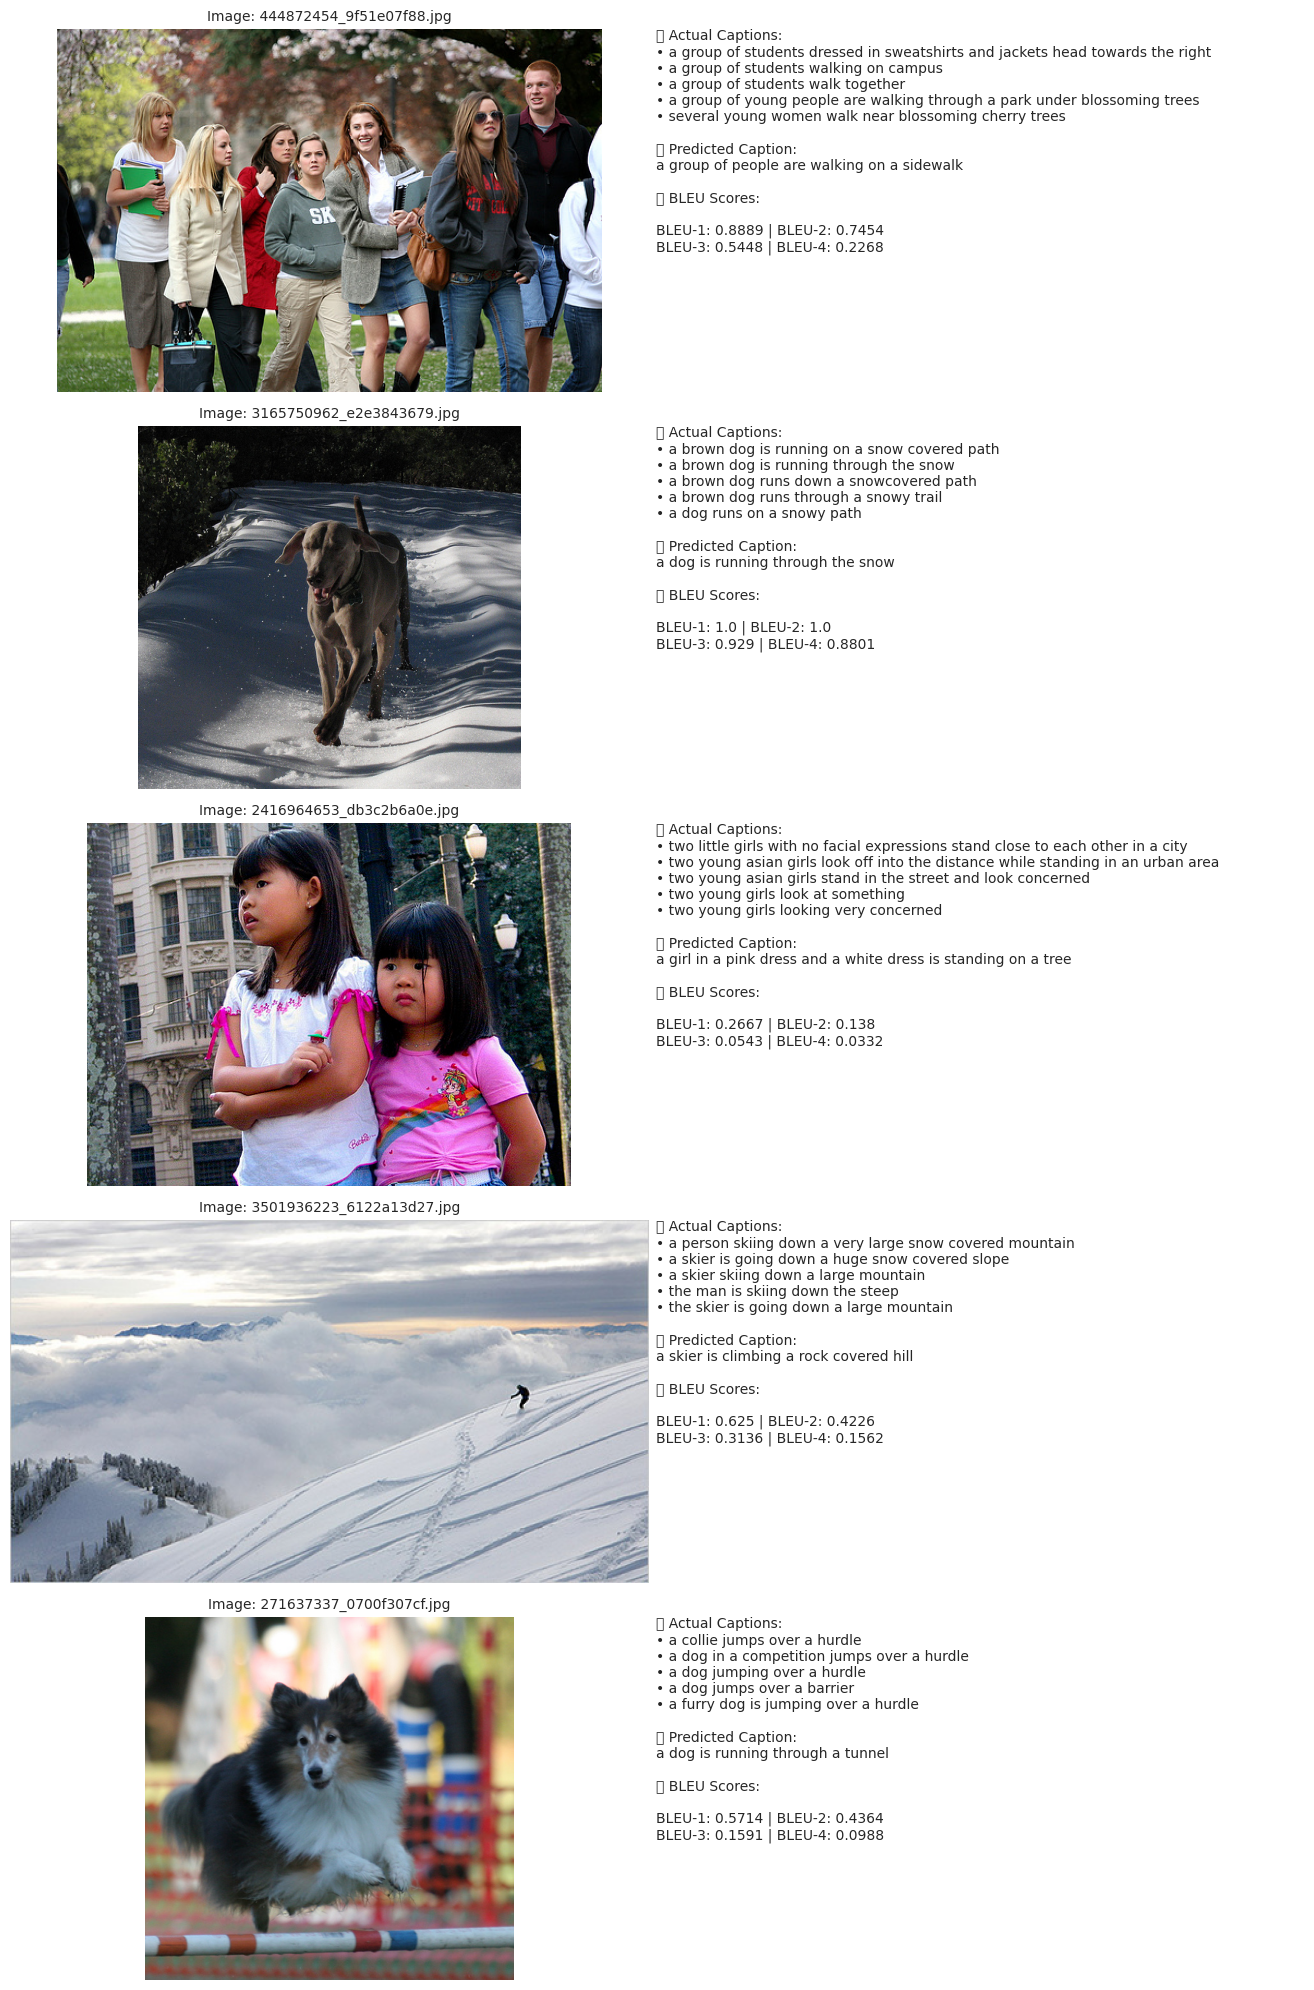

In [198]:
show_side_by_side_caption_eval(test_actual_captions, generated_captions, images_directory, num_samples=5)



In [208]:
list(test_actual_captions.keys())[100:115]


['2160266952_a2ab39191b.jpg',
 '2164363131_6930455d45.jpg',
 '2171154778_8189169336.jpg',
 '2172493537_128bc8b187.jpg',
 '217583047_5e93e1e119.jpg',
 '2176147758_9a8deba576.jpg',
 '2176980976_7054c99621.jpg',
 '2180886307_5156460b2c.jpg',
 '2182050469_1edac0bc60.jpg',
 '2187904131_96ea83b9b5.jpg',
 '2192411521_9c7e488c5e.jpg',
 '219301555_17883a51bd.jpg',
 '2198964806_c57b0534d3.jpg',
 '2206960564_325ed0c7ae.jpg',
 '2208631481_3e4a5675e1.jpg']

In [199]:
list(test_actual_captions.keys())[:30
]


['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1075881101_d55c46bece.jpg',
 '1087539207_9f77ab3aaf.jpg',
 '109823395_6fb423a90f.jpg',
 '112243673_fd68255217.jpg',
 '1138784872_69ade3f2ab.jpg',
 '1142283988_6b227c5231.jpg',
 '1149179852_acad4d7300.jpg',
 '1155138244_859fd6e079.jpg',
 '1163282319_b729b24c46.jpg',
 '1167669558_87a8a467d6.jpg',
 '1176580356_9810d877bf.jpg',
 '118187095_d422383c81.jpg',
 '1184967930_9e29ce380d.jpg',
 '1204996216_71d7519d9a.jpg',
 '1235580648_7eebaed9bc.jpg',
 '1244140539_da4804d828.jpg',
 '1248734482_3038218f3b.jpg',
 '124972799_de706b6d0b.jpg',
 '1260816604_570fc35836.jpg',
 '1282392036_5a0328eb86.jpg',
 '1290894194_8a4ffdc7eb.jpg',
 '1295698260_e10c53c137.jpg',
 '1298295313_db1f4c6522.jpg',
 '1298866571_b4c496b71c.jpg',
 '1317292658_ba29330a0b.jpg',
 '1324816249_86600a6759.jpg',
 '1337792872_d01a390b33.jpg',
 '1342766791_1e72f92455.jpg']